# Library

In [2]:
# basis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer

# Model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, label_binarize
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import *

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Seed Data

In [4]:
df = pd.read_csv('Class_Seeds.csv')
df.head()

,Area,Perimeter,Compactness,KernelLength,KernelWidth,AsymCoeff,KernelGrov_Length,Class
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               210 non-null    float64
 1   Perimeter          210 non-null    float64
 2   Compactness        210 non-null    float64
 3   KernelLength       210 non-null    float64
 4   KernelWidth        210 non-null    float64
 5   AsymCoeff          210 non-null    float64
 6   KernelGrov_Length  210 non-null    float64
 7   Class              210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB


In [6]:
# Checking missing data
df.isnull().sum()

Area                 0
Perimeter            0
Compactness          0
KernelLength         0
KernelWidth          0
AsymCoeff            0
KernelGrov_Length    0
Class                0
dtype: int64

In [7]:
# Checking data duplicate
df[df.duplicated()].count()

Area                 0
Perimeter            0
Compactness          0
KernelLength         0
KernelWidth          0
AsymCoeff            0
KernelGrov_Length    0
Class                0
dtype: int64

In [8]:
df.describe()

,Area,Perimeter,Compactness,KernelLength,KernelWidth,AsymCoeff,KernelGrov_Length,Class
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


# EDA

## Count the seeds class

In [11]:
def single_plot_distribution(column_name, dataframe):
    # Get the value counts of the specified column
    value_counts = dataframe[column_name].value_counts()

    # Set up the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5)) 

    # Donut pie chart
    ax1.pie(value_counts, autopct='%0.0001f%%', startangle=90, pctdistance=0.5, labels=['Class-1','Class-2','Class-3'])
    ax1.set_title(f'Distribution of {column_name}', fontsize=10)

    # Bar chart
    sns.barplot(x=value_counts.index, y=value_counts.values, ax=ax2) 
    ax2.set_title(f'Count of {column_name}', fontsize=16)
    ax2.set_xlabel(column_name, fontsize=14)
    ax2.set_ylabel('Count', fontsize=14)

    # Show the plots
    plt.tight_layout()
    plt.show()

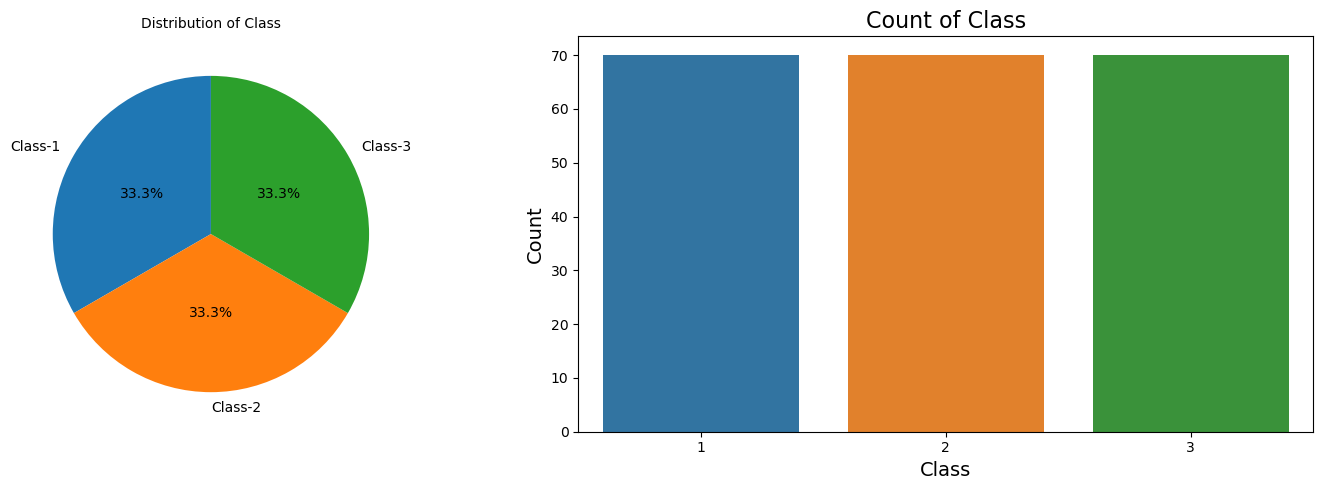

Class
1    70
2    70
3    70
Name: count, dtype: int64

In [12]:
single_plot_distribution('Class', df)
df['Class'].value_counts()

## Find Outlier

In [14]:
features = df.drop('Class', axis=1).columns

In [15]:
from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        outlier_indices.extend(outlier_list_col)

    outlier_indices_counter = Counter(outlier_indices)        
    multiple_outliers = [ k for k, v in outlier_indices_counter.items() if v > n]
    
    return multiple_outliers, outlier_indices

In [16]:
outliers_to_drop, outliers = detect_outliers(df, 2, features)
print(f"{len(outliers)} samples contain outliers, {len(outliers_to_drop)} of them are outliers in more then two features.")

5 samples contain outliers, 0 of them are outliers in more then two features.


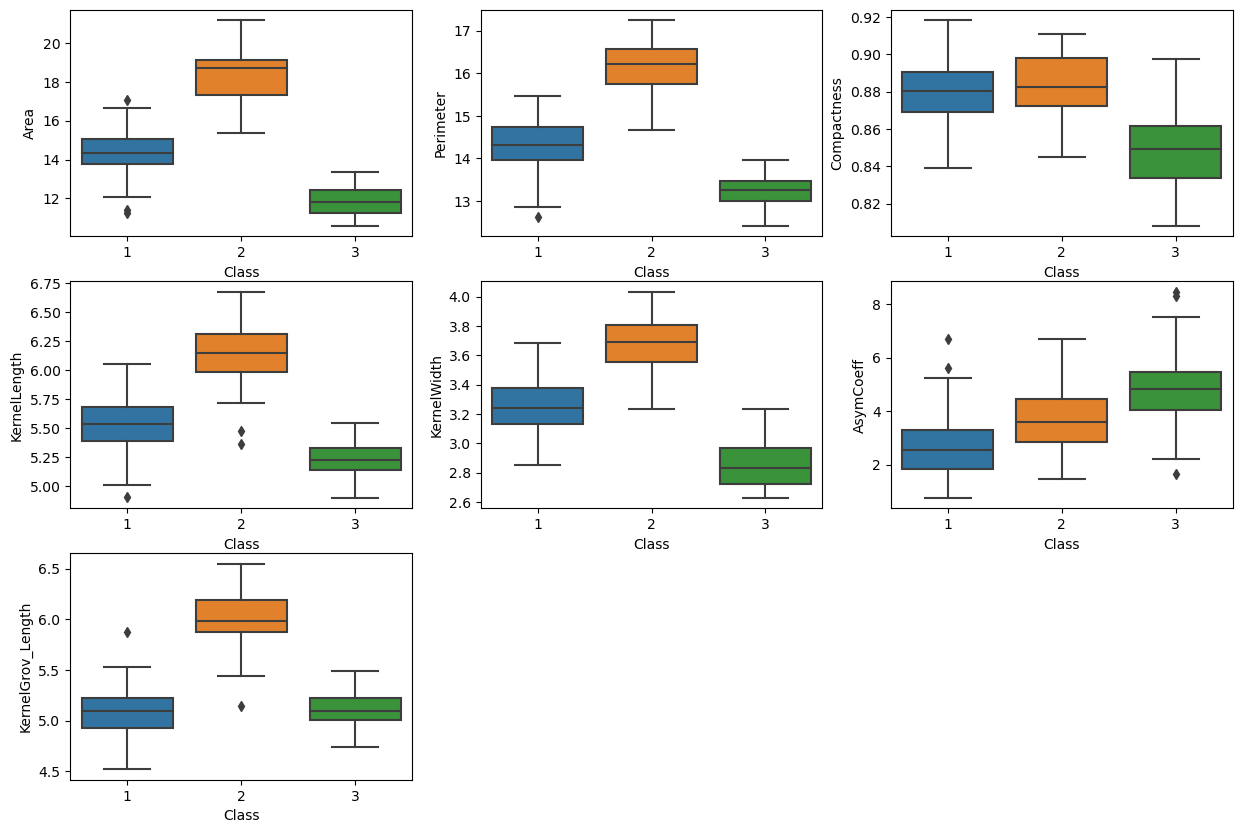

In [17]:
plt.figure(figsize=(15,10))
plt.tight_layout()
variables = ['Area', 'Perimeter', 'Compactness', 'KernelLength', 'KernelWidth', 'AsymCoeff', 'KernelGrov_Length']
for i in range(len(variables)):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=df, y=df[variables[i]], x=df['Class']);

# Modeling

## Visualizstion of data by label (t-SNE)

In [20]:
tsne = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df)
tsne.shape

(210, 3)

[Text(0.5, 0, 'X1'),
 Text(0, 0.5, 'X2'),
 Text(0.5, 1.0, 'Visualization of data in two dimentions by t-SNE')]

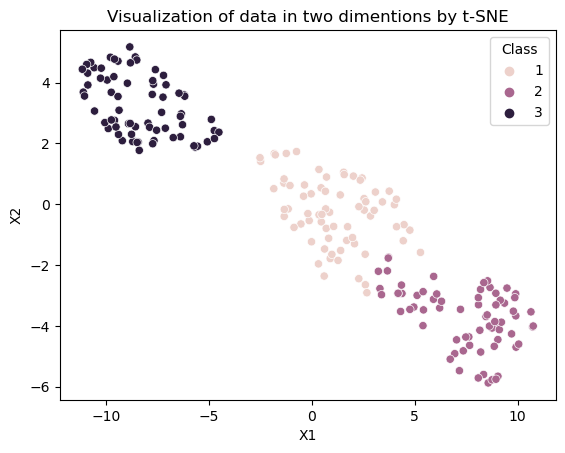

In [21]:
g = sns.scatterplot(data=tsne, x=tsne[:,0], y=tsne[:,2], hue=df.Class)
g.set(xlabel='X1', ylabel='X2', title='Visualization of data in two dimentions by t-SNE')

## Unsupervised learning

In [23]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df)

[Text(0.5, 0, 'X1'),
 Text(0, 0.5, 'X2'),
 Text(0.5, 1.0, 'Visualization of data in 2-D by t-SNE')]

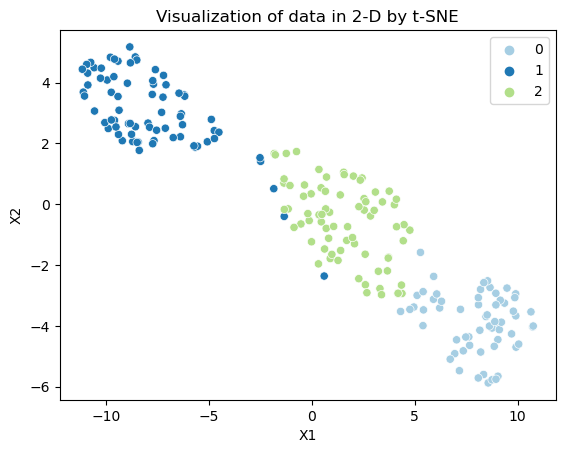

In [24]:
g = sns.scatterplot(data=tsne, x=tsne[:,0], y=tsne[:,2], hue=kmeans.labels_, palette="Paired")
g.set(xlabel='X1', ylabel='X2', title='Visualization of data in 2-D by t-SNE')

## Skewness

In [26]:
# check skewness for all numerical features
skewed_feats = df.apply(lambda x: x.skew()).sort_values(ascending=False)
print("\nSkew in numerical features (origin df): \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
skewness.head(11)


Skew in numerical features (origin df): 



,Skew
KernelGrov_Length,0.562
KernelLength,0.525
AsymCoeff,0.402
Area,0.400
Perimeter,0.387
KernelWidth,0.134
Class,0.000
Compactness,-0.538


In [27]:
['Area', 'Perimeter', 'Compactness', 'KernelLength', 'KernelWidth', 'AsymCoeff', 'KernelGrov_Length']
# Applying Yeo-Johnson Transformation
df['KernelGrov_Length'], _ = yeojohnson(df['KernelGrov_Length'])
df['KernelLength'], _ = yeojohnson(df['KernelLength'])
df['Compactness'], _ = yeojohnson(df['Compactness'])

print(f"Skewness KernelGrov_Length after Yeo-Johnson Transformation: {df['KernelGrov_Length'].skew():.5f}")
print(f"Skewness KernelLength after Yeo-Johnson Transformation: {df['KernelLength'].skew():.5f}")
print(f"Skewness Compactness afer Yeo-Johnson Transformation: {df['Compactness'].skew():.5f}")

Skewness KernelGrov_Length after Yeo-Johnson Transformation: 0.09006
Skewness KernelLength after Yeo-Johnson Transformation: 0.09413
Skewness Compactness afer Yeo-Johnson Transformation: -0.04547


## Scaller and test-train data

In [29]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

# adjusting the format of the labebl to xgboost model
le = LabelEncoder()
y_train_gb = le.fit_transform(y_train)

## Choose best parameter 

In [ ]:
# choosing best estimators for Random Forest model: 
param_grid = {'max_depth': [2, 3, 4, 5, 6, 10, 100, 300], 'n_estimators':[100, 500, 1000]}  # what about n_estimators?? 
rf_model = GridSearchCV(RandomForestClassifier(random_state=42), param_grid)
rf_model.fit(X_train, y_train)
print(f"Best estimators for Random Forest: {rf_model.best_estimator_}")

# choosing best estimators for AdaBoost model:
param_grid = {'n_estimators': [10, 20, 50, 100], 'learning_rate': [0.1, 0.2, 0.5, 0.7, 0.8, 1]}  
ada_model = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid)
ada_model.fit(X_train, y_train)
print(f"Best estimators for AdaBoost: {ada_model.best_estimator_}")

# choosing best estimators for svm model: 
param_grid = {'kernel': ['linear','poly','rbf'], 'C': [0.001, 0.01, 0.1, 1, 10],
                  'gamma': [1, 0.1]}  
svm_model = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid)
svm_model.fit(X_train_scaled, y_train)
print(f"Best estimators for SVM: {svm_model.best_estimator_}")

# choosing best estimators for KNN model:
param_grid = {'n_neighbors': list(range(3, 16, 2))}  
knn_model = GridSearchCV(KNeighborsClassifier(), param_grid)
knn_model.fit(X_train_scaled, y_train)
print(f"Best estimators for K-Nearest Neighbor: {knn_model.best_estimator_}")

# choosing best estimators for Gradient Boosting model:
param_grid = {'n_estimators': [10, 20, 50, 100, 300, 500], 'learning_rate': [0.1, 0.8, 1], 'max_depth' : [1, 2, 3, 5]}  
gb_model = GridSearchCV(XGBClassifier(random_state=42), param_grid)
gb_model.fit(X_train, y_train_gb)
print(f"Best estimators for Gradient Boosting: {gb_model.best_estimator_}")

## Modeling

In [ ]:
rf = RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)
ada = AdaBoostClassifier(learning_rate=0.8, random_state=42)
svm = SVC(C=10, class_weight='balanced', gamma=1, kernel='linear', random_state=42) 
knn = KNeighborsClassifier(n_neighbors=3)
gb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring='f1_micro',
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_micro')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    return test_scores_mean, test_scores_std


rf_mean, rf_std = plot_learning_curve(rf,"Random Forest learning curves",X_train,y_train,cv=5)
ada_mean, ada_std = plot_learning_curve(ada,"AdaBoost learning curves",X_train,y_train,cv=5)
svm_mean, svm_std = plot_learning_curve(svm,"SVM learning curves",X_train_scaled,y_train,cv=5)
knn_mean, knn_std = plot_learning_curve(knn,"K-Nearest Neighbor learning curves",X_train_scaled,y_train,cv=5)
gb_mean, gb_std = plot_learning_curve(gb,"Gradient Boosting learning curves",X_train,y_train_gb,cv=5)

In [ ]:
# printing accuracy and std of validation for each model
print(f"\nRandom Forest score: {rf_mean.mean():.2f} ({rf_std.mean():.2f})\n")
print(f"\nAdaBoost score: {ada_mean.mean():.2f} ({ada_std.mean():.2f})\n")
print(f"\nSVM score: {svm_mean.mean():.2f} ({svm_std.mean():.2f})\n")
print(f"\nK-Nearest Neighbor score: {knn_mean.mean():.2f} ({knn_std.mean():.2f})\n")
print(f"\nGradient Boosting score: {gb_mean.mean():.2f} ({gb_std.mean():.2f})\n")

## Ensemble 3 top models

In [ ]:
estimators = [('svm_stck', make_pipeline(scaler, SVC(kernel='linear', C=10, class_weight='balanced', probability=True, gamma=1, random_state=42))),
              ('knn_stck', make_pipeline(scaler, KNeighborsClassifier(n_neighbors=3))), 
              ('rf_stck', RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42))]


X_train67, X_val, y_train67, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, stratify=y_train)

In [ ]:
final_estimator = LogisticRegression(max_iter=400) 

stck = StackingClassifier(estimators=estimators, final_estimator=final_estimator, stack_method='predict')

accuracy = stck.fit(X_train67, y_train67).score(X_val, y_val)
print(f"\nStacking model accuracy: {accuracy:.2f}\n")

stck_pred = stck.predict(X_val)
f1 = f1_score(y_val, stck_pred, average='macro')
print(f"\nStacking model f1 score: {f1:.2f}\n")

__It's lower than maximum score in simple model__

## Voting model

In [ ]:
vote = VotingClassifier(estimators=estimators, voting='soft')
accuracy = vote.fit(X_train67, y_train67).score(X_val, y_val)
print(f"\nMajority vote accuracy: {accuracy:.2f}\n")

vote_pred = vote.predict(X_val)
f1 = f1_score(y_val, vote_pred, average='macro')
print(f"\nMajority vote model f1 score: {f1:.2f}\n")

__It's lower than maximum score in simple model__

## Conclusion

Models that we can use for this data are:
1. SVC (0.93)
2. Random Forest Classifier (0.92)
3. K-Nearest Neighbor Classifier (0.92)
4. XGB Classifier (0.91)
5. AdaBoost Classifier (0.84)